In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.contrib import rnn
from util.CalcReturns import CalcReturns

In [2]:
def recurrent_neural_network_model(input):

    layer = {'w' : tf.Variable(tf.random_normal([num_hidden, n_classes])),
             'b' : tf.Variable(tf.random_normal([n_classes]))}
    
    input = tf.unstack(input, timesteps, 1)    
    
    lstm_cell = rnn.BasicLSTMCell(num_hidden)    
    outs, state = rnn.static_rnn(lstm_cell, input, dtype=tf.float32)
    
    output = tf.add(tf.matmul(outs[-1], layer['w']), layer['b'], name='nn')    
    return output

def train_and_save_nn(x_data,y_data):
    x_train = tf.placeholder('float', [None, timesteps, num_input], name='x')
    y_train = tf.placeholder('float', [None, n_classes], name='y')
    
    nn = recurrent_neural_network_model(x_train)
    cost = tf.reduce_mean(tf.abs(tf.subtract(nn, y_train)), name='cost')    
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01).minimize(cost)   
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)   
    
    correct = tf.equal(tf.argmax(nn,1), tf.argmax(y_train, 1), name='correct')
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'), name = 'accuracy')
    
    saver = tf.train.Saver()
    
    with tf.Session() as session:
        
        session.run(tf.initialize_all_variables())
        
        epoch_loss = 0
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for i in range(int(len(X_train)/batch_size)):
                
                batch_x = x_data[i*batch_size : (i+1)*batch_size]
                batch_y = y_data[i*batch_size : (i+1)*batch_size]
               
                batch_x = batch_x.reshape((batch_size, timesteps, num_input))
                
                _, c = session.run([optimizer, cost], feed_dict = {x_train: batch_x, y_train: batch_y})
                epoch_loss += c
                
            if epoch % 1000 == 0:
                print('Epoch', epoch, 'completed out of', hm_epochs, 'loss', epoch_loss)
               
        saver.save(session, 'data/fxrn.ckpt')        
        print('Last epoch loss: ', epoch_loss)
        
    return nn, correct, accuracy

def test_nn(x_test, y_test):
    with tf.Session() as session:
        saver = tf.train.import_meta_graph('data/fxrn.ckpt.meta')
        saver.restore(session, tf.train.latest_checkpoint('data/'))
        
        graph    = tf.get_default_graph()        
                
        x  = graph.get_tensor_by_name('x:0')        
        nn = graph.get_tensor_by_name('nn:0')        

        inputs  = x_test        
        inputs  = np.reshape(inputs, (testsize, 1, 1))
        
        outputs = session.run([nn], feed_dict = {x: inputs})
        predicted = outputs[0]        

        # Visualising the results        
        #plt.plot(x_test,    color = 'green', label = 'Input')
        plt.plot(y_test,    color = 'blue',  label = 'Actual')
        plt.plot(predicted, color = 'red',   label = 'Predicted')

        plt.title('Prediction')
        plt.xlabel('Time')
        plt.ylabel('Series')
        plt.legend()
        plt.show()

In [3]:
N  = 4096
timesteps  = 1
num_input  = 1
n_classes  = 1
step       = num_input * timesteps

lag        = 1
testsize   = 16
trainsize  = N - testsize - 1024

hm_epochs  = 100000
num_hidden = 4
batch_size = 128

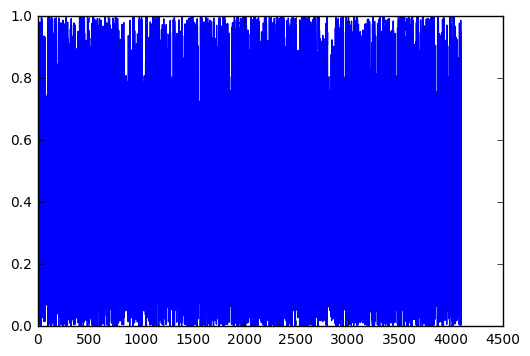

In [4]:
d0 = math.sin(1)
d1 = math.sin(2)

L  = 3

D = []
D.append(d0)
D.append(d1)

for i in range(0, N):
    n = len(D)
    
    v_1 = D[n-1]
    v_2 = D[n-2]
    
    D.append(1 - 4*v_2 + 4*v_2*v_2)
    
plt.plot(D)
plt.show()

def plot_phase_space(S, Lag):
    x = S[0:N-Lag]
    y = S[Lag:N]

    plt.scatter(x,y)
    plt.show()
    
#plot_phase_space(D, 1)
#plot_phase_space(D, 2)
#plot_phase_space(D, 3)
#plot_phase_space(D, 4)
#plot_phase_space(D, 5)
#plot_phase_space(D, 6)

data_set = D


In [5]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

# Importing the training set
#data_set = pd.read_csv('EURUSD1.csv')
data_set = data_set[:trainsize + lag + testsize + lag + 1]

#data_set = data_set.iloc[:,1:2].values

returns = np.reshape(CalcReturns(data_set), (trainsize + lag + testsize + lag,1))
returns = sc.fit_transform(returns)

testing_set  = returns[-testsize-lag:]
training_set = returns[:trainsize+lag]

# Getting the inputs and the ouputs
X_train = training_set[0:trainsize]
Y_train = training_set[lag:trainsize+lag]

X_test = testing_set[0:testsize]
Y_test = testing_set[lag:testsize+lag]

# Reshaping
X_train = np.reshape(X_train, (trainsize, 1, 1))

In [9]:
train_and_save_nn(X_train, Y_train)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 0, 'completed out of', 100000, 'loss', 15.518560945987701)
('Epoch', 1000, 'completed out of', 100000, 'loss', 1.0391130037605762)
('Epoch', 2000, 'completed out of', 100000, 'loss', 1.0285352654755116)
('Epoch', 3000, 'completed out of', 100000, 'loss', 1.002024095505476)
('Epoch', 4000, 'completed out of', 100000, 'loss', 0.98632848262786865)
('Epoch', 5000, 'completed out of', 100000, 'loss', 0.97614972665905952)
('Epoch', 6000, 'completed out of', 100000, 'loss', 0.97124060988426208)
('Epoch', 7000, 'completed out of', 100000, 'loss', 0.96720265597105026)
('Epoch', 8000, 'completed out of', 100000, 'loss', 0.96370286121964455)
('Epoch', 9000, 'completed out of', 100000, 'loss', 0.96058685332536697)
('Epoch', 10000, 'completed out of', 100000, 'loss', 0.95778235420584679)
('Epoch', 11000, 'completed out of', 100000, 'loss', 0.95521313324570656)
('Epoch', 12000, 'completed out of', 100000, 'loss', 0.9

(<tf.Tensor 'nn:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'correct:0' shape=(?,) dtype=bool>,
 <tf.Tensor 'accuracy:0' shape=() dtype=float32>)

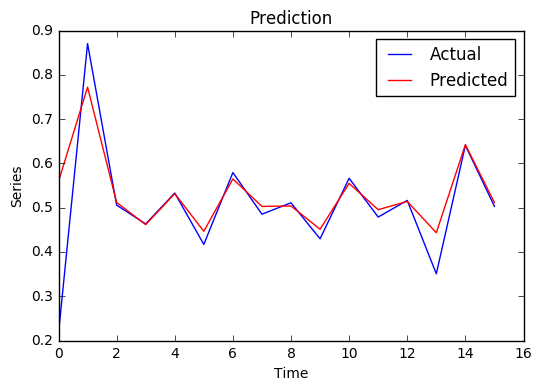

In [6]:
test_nn(X_test, Y_test)


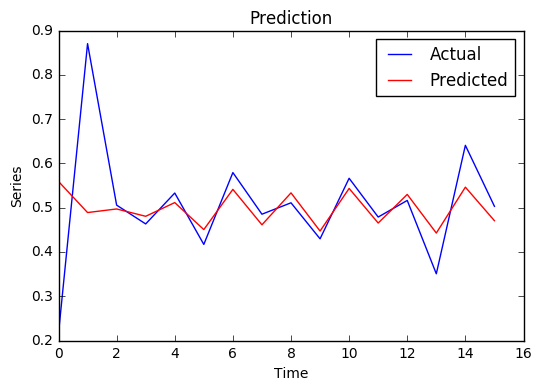

In [7]:
x_test = X_test

predicted = []

with tf.Session() as session:
    saver = tf.train.import_meta_graph('data/fxrn.ckpt.meta')
    saver.restore(session, tf.train.latest_checkpoint('data/'))
        
    graph    = tf.get_default_graph()        
                
    x  = graph.get_tensor_by_name('x:0')        
    nn = graph.get_tensor_by_name('nn:0')        

    inputs  = x_test[0]
    inputs  = np.reshape(inputs, (1, 1, 1))
    
    for i in range(0,len(x_test)):    
        outputs = session.run([nn], feed_dict = {x: inputs})
        inputs = np.reshape(outputs[0], (1, 1, 1))
        predicted.append(outputs[0][0])

    # Visualising the results        
    #plt.plot(x_test,    color = 'green', label = 'Input')
    plt.plot(Y_test,    color = 'blue',  label = 'Actual')
    plt.plot(predicted, color = 'red',   label = 'Predicted')

    plt.title('Prediction')
    plt.xlabel('Time')
    plt.ylabel('Series')
    plt.legend()
    plt.show()